In [13]:
import pandas as pd
import networkx as nx
import numpy as np

# Read in the CSV files

# 55% SAR count
#accounts_df = pd.read_csv("../datasets/60K_60_sar_count/account_attributes.csv")
#transactions_df = pd.read_csv("../datasets/60K_60_sar_count/transactions.csv")

# 10% SAR count
#accounts_df = pd.read_csv("../datasets/60K_10_sar_count/account_attributes.csv")
#transactions_df = pd.read_csv("../datasets/60K_10_sar_count/transactions.csv")

# 5% SAR count
accounts_df = pd.read_csv("../datasets/60K_05_sar_count/account_attributes.csv")
transactions_df = pd.read_csv("../datasets/60K_05_sar_count/transactions.csv")

# 1% SAR count
#accounts_df = pd.read_csv("../datasets/60K_01_sar_count/account_attributes.csv")
#transactions_df = pd.read_csv("../datasets/60K_01_sar_count/transactions.csv")





In [14]:
nodes_df = accounts_df
edges_df = transactions_df


nodes_df
#edges_df
#nodes_df.node_isSar.sum()/len(nodes_df)

,ED,SED,comm_size,GAW,GAW10,GAW20,Std_Degree,node_amt_total_in,node_amt_min_in,node_amt_max_in,...,node_amt_min_out,node_amt_max_out,node_amt_mean_out,node_amt_median_out,node_amt_std_out,node_deg_out,node_deg_out_unique,node_deg_total,id,node_isSar
0,0.007439,0.000025,297.0,3.090529,0.000000,0.000000,0.634113,69653.22,100.14,994.42,...,102.29,996.61,585.453301,587.980,268.918911,103.0,18.0,227.0,0.0,0.0
1,0.005630,0.000013,419.0,0.000000,0.000000,0.000000,4.195880,165626.54,100.04,999.31,...,102.04,994.19,561.758447,597.160,271.823100,103.0,103.0,419.0,1.0,0.0
2,0.013384,0.000085,158.0,0.000000,0.000000,0.000000,4.077155,67880.36,102.28,991.24,...,101.85,997.09,558.403333,545.795,269.899887,102.0,102.0,222.0,2.0,0.0
3,0.005912,0.000014,413.0,0.000000,0.000000,0.000000,7.312426,439010.89,17.79,998.95,...,105.06,994.41,522.874854,502.230,259.529413,103.0,103.0,895.0,3.0,0.0
4,0.005912,0.000014,413.0,0.000000,0.000000,0.000000,7.342108,648029.55,87.25,999.40,...,103.19,973.84,521.006311,529.580,263.394798,103.0,103.0,1296.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60210,0.000000,0.000000,1.0,3.090529,3.090529,3.090529,-0.167284,0.00,0.00,0.00,...,0.00,0.00,0.000000,0.000,0.000000,0.0,0.0,0.0,60210.0,0.0
60211,0.000000,0.000000,1.0,3.090529,3.090529,3.090529,-0.167284,0.00,0.00,0.00,...,0.00,0.00,0.000000,0.000,0.000000,0.0,0.0,0.0,60211.0,0.0
60212,0.000000,0.000000,1.0,3.090529,3.090529,3.090529,-0.167284,0.00,0.00,0.00,...,0.00,0.00,0.000000,0.000,0.000000,0.0,0.0,0.0,60212.0,0.0
60213,0.000000,0.000000,1.0,3.090529,3.090529,3.090529,-0.167284,0.00,0.00,0.00,...,0.00,0.00,0.000000,0.000,0.000000,0.0,0.0,0.0,60213.0,0.0


In [15]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.transforms import NormalizeFeatures

def visualize(h, color):
    z = TSNE(n_components=2, learning_rate='auto',
             init='random').fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

def print_model_size(model):
    tot = sum([p.numel() for p in model.parameters() if p.requires_grad])
    out = f"Number of model ({model.__class__.__name__}) parameters:{tot:10d}"
    print("=" * len(out))
    print(out)

2.0.1+cu118


In [16]:
x_np = nodes_df.to_numpy()
x = x_np[:,0:-2]
print(x.shape, x_np.shape)

(60215, 24) (60215, 26)


In [17]:
from torch.utils.data import random_split
# Define your graph
x = torch.nn.functional.normalize(torch.tensor(x),dim=0).to(torch.float32)  # (n x features)
edge_index =  torch.stack([torch.tensor(edges_df.orig_acct.to_numpy()),torch.tensor(edges_df.bene_acct.to_numpy())],dim=-1).T  # Define your edge index
#edge_attr = torch.nn.functional.normalize(torch.tensor(np.array(edges_df[['amount','oldBalanceOrig', 'newBalanceOrig', 'oldBalanceDest', 'newBalanceDest','isFlaggedFraud','isUnauthorizedOverdraft','action_CASH_IN','action_CASH_OUT','action_DEBIT','action_PAYMENT','action_TRANSFER']].values,dtype='float32')),dim=0) # edge features
edge_weight = torch.nn.functional.normalize(torch.tensor(edges_df.base_amt.to_numpy()),dim=0).long()
y =  torch.tensor(nodes_df.node_isSar.to_numpy().astype(int),dtype=torch.long) # target values

# Bitflip the tensor
#y = y ^ torch.tensor([1], dtype=torch.uint8).expand_as(y)


train_size = int(0.35 * len(y))  # 60% of the dataset for training
val_size = int(0.15 * len(y))    # 20% of the dataset for validation
test_size = len(y) - train_size - val_size  # Remaining 20% for testing

train_dataset, val_dataset, test_dataset = random_split(y, [train_size, val_size, test_size])

# Create masks for train, validation, and test sets
train_mask = torch.zeros(len(y), dtype=torch.bool)
val_mask = torch.zeros(len(y), dtype=torch.bool)
test_mask = torch.zeros(len(y), dtype=torch.bool)

train_mask[train_dataset.indices] = True
val_mask[val_dataset.indices] = True
test_mask[test_dataset.indices] = True

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [19]:
from torch_geometric.data import Data
# Load your data into PyTorch Geometric's Data class
#data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y,train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
#data = Data(x=x, edge_index=edge_index, y=y,train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight, y=y,train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
data.to(device)

Data(x=[60215, 24], edge_index=[2, 992675], y=[60215], edge_weight=[992675], train_mask=[60215], val_mask=[60215], test_mask=[60215])

In [20]:
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')

print('==============================')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(f'Is weighted: {data.edge_weight is not None}')

print('==============================')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')

Number of nodes: 60215
Number of edges: 992675
Average node degree: 16.49
Has isolated nodes: True
Has self-loops: False
Is undirected: False
Is weighted: True
Number of training nodes: 21075
Training node label rate: 0.35


In [21]:
from sklearn.ensemble import RandomForestClassifier



trainX = data.x[data.train_mask + data.val_mask].detach().cpu().numpy()
trainY = data.y[data.train_mask + data.val_mask].detach().cpu().numpy()

testX = data.x[data.test_mask].detach().cpu().numpy()
testY = data.y[data.test_mask].detach().cpu().numpy()

clf = RandomForestClassifier(max_depth=20, random_state=0, n_estimators=200)

clf.fit(trainX, trainY)

RandomForestClassifier(max_depth=20, n_estimators=200, random_state=0)

In [22]:
y_pred_RF = clf.predict(testX)

Precision: 0.97
Recall: 0.68
F1-score: 0.80


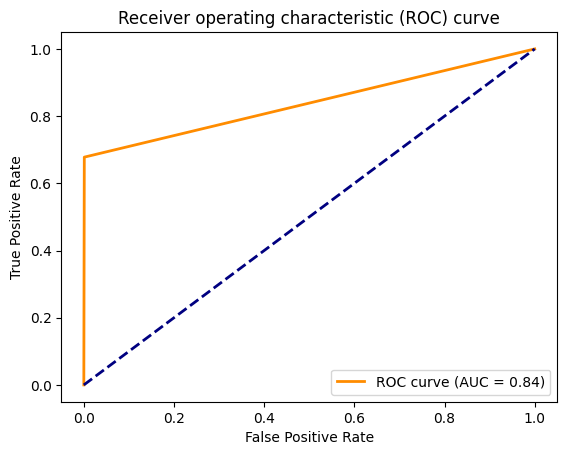

In [23]:
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support
y_true = testY
y_pred = y_pred_RF
#print(np.sum(test_pred))
#print(np.sum(y_true)/len(y_true))


# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_RF, average='binary')

print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1_score))

# Generate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

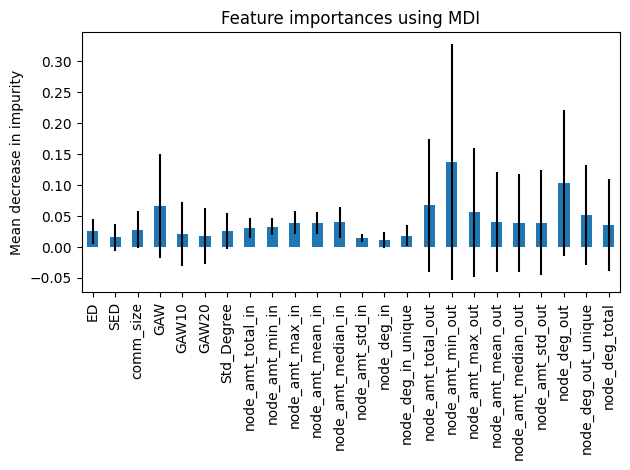

In [12]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
import pandas as pd

forest_importances = pd.Series(importances, index=nodes_df.columns[:-2])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

<BarContainer object of 21 artists>

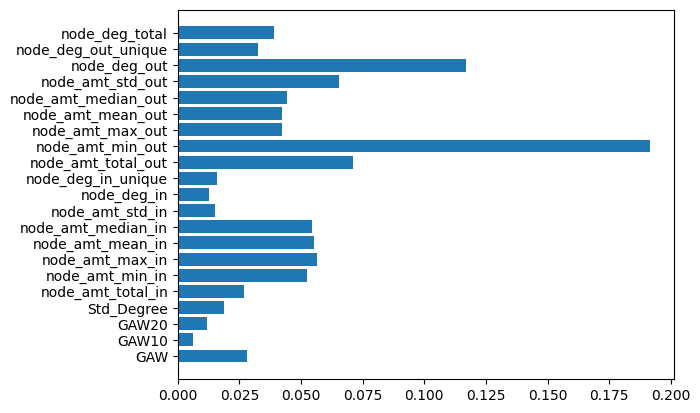

In [401]:
plt.barh(nodes_df.columns[:-2],  clf.feature_importances_)

In [399]:
nodes_df.columns[:]

Index(['GAW', 'GAW10', 'GAW20', 'Std_Degree', 'node_amt_total_in',
       'node_amt_min_in', 'node_amt_max_in', 'node_amt_mean_in',
       'node_amt_median_in', 'node_amt_std_in', 'node_deg_in',
       'node_deg_in_unique', 'node_amt_total_out', 'node_amt_min_out',
       'node_amt_max_out', 'node_amt_mean_out', 'node_amt_median_out',
       'node_amt_std_out', 'node_deg_out', 'node_deg_out_unique',
       'node_deg_total', 'id', 'node_isSar'],
      dtype='object')

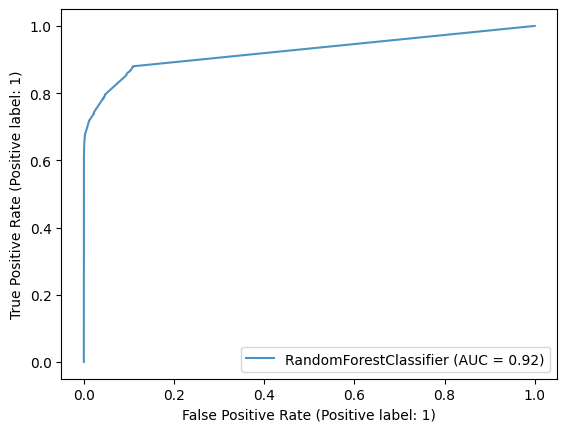

In [25]:
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay
rfc = RandomForestClassifier(n_estimators=10, random_state=42)
rfc.fit(trainX, trainY)
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rfc, testX, testY, ax=ax, alpha=0.8)

plt.show()

In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_pred_test = rfc.predict(testX)
accuracy_score(testY, y_pred_test)
confusion_matrix(testY, y_pred_test)
print(classification_report(testY, y_pred_test))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     28478
           1       0.93      0.68      0.78      1630

    accuracy                           0.98     30108
   macro avg       0.95      0.84      0.89     30108
weighted avg       0.98      0.98      0.98     30108

